In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfaidx import Fasta
import logomaker

In [2]:
nlinear_loc_arr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/non_linear/locations.npy"
nlinear_seq_arr_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/non_linear/seq_attr.npy"
nlinear_pred_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/CC/peaks_vs_notpeaks/non_linear/resnet_mlp.csv.gz"

genome_fasta = "/data5/deepro/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"

In [3]:
def read_pred_files(pred_file, seq_arr_file, loc_arr_file):
    pred_df = pd.read_csv(pred_file, header=None, names=["ypred", "ytarget", "chrm", "start", "end"])
    seq_arr = np.load(seq_arr_file)
    loc_arr = np.load(loc_arr_file)
    return pred_df, seq_arr, loc_arr

def create_seq_attr_df(seq, seq_attr):
    data_arr = np.zeros((len(seq), 4))
    nts = ["A", "T", "G", "C"]
    seq_idx = dict(zip(nts, range(len(nts))))
    for i, (s, sq) in enumerate(zip(seq, seq_attr)):
        data_arr[i, seq_idx[s]] = sq
    data_df = pd.DataFrame(data_arr, columns=nts)
    return data_df

def get_complement(seq):
    complement_dict = {
        "A": "T",
        "G": "C",
        "T": "A",
        "C": "G",
        "N": "N"
        }    
    rev_comp_seq = "".join([complement_dict[s] for s in seq])
    return rev_comp_seq

def create_seqattr_figure(seq, seq_attr, nrows=5,):
    seq_df = create_seq_attr_df(seq, seq_attr)
    bp_per_row=len(seq)//nrows
    fig, ax = plt.subplots(nrows, 1, figsize=(15, 10), sharey=True)
    start = 0
    for row in range(nrows):
        # create Logo object
        nn_logo = logomaker.Logo(seq_df.iloc[start:start+bp_per_row], ax=ax[row],)
        nn_logo.ax.set_xticks([])
        start += bp_per_row
        ax[row].spines[['right', 'top', "bottom"]].set_visible(False)
        ax[row].xaxis.set_visible(False)
        # ax[row].set_yticks([])
        ax[row].set_ylim(seq_attr.min(), seq_attr.max())
    return fig, ax

In [6]:
genome = Fasta(genome_fasta, as_raw=True)

In [5]:
nlinear_pred_df, nlinear_seq_arr, nlinear_loc_arr = read_pred_files(nlinear_pred_file, nlinear_seq_arr_file, nlinear_loc_arr_file)

In [12]:
top_pred_idxs = nlinear_pred_df.loc[(nlinear_pred_df.ytarget==1)&(nlinear_pred_df.ypred>0.99)].sort_values("ypred", ascending=False).index

In [14]:
def get_seq_info(idx, reverse=False):
    chrm, start, end = nlinear_pred_df.iloc[idx].loc[["chrm", "start", "end"]].values
    seq = list(genome.get_seq(chrm, start, end))
    if reverse:
        seq = get_complement(seq)
    seq_attr = nlinear_seq_arr[idx]
    return seq, seq_attr, (chrm, start, end)

(<Figure size 1500x1000 with 5 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

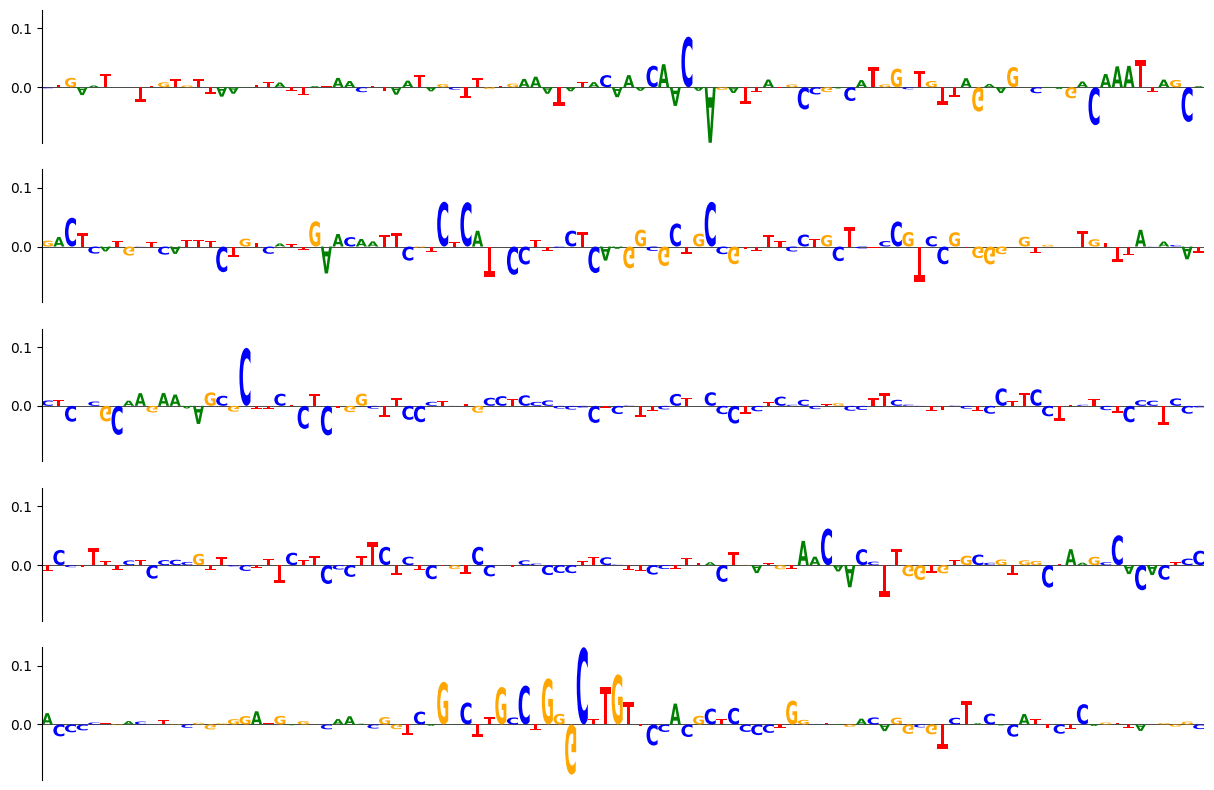

In [32]:
s, sa, (chrm, start, end) = get_seq_info(top_pred_idxs[15]) # good examples 2,5,6,7,11,14 ; very good 8, 
create_seqattr_figure(s, sa)